In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import sys
import matplotlib
import seaborn as sns
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})
pd.set_option('max_rows', 100)
from scipy import stats

# Time-of-day factor

In [275]:
## Read in all files from TAQ

# Fix forward/backslashes in directory name
taq_folder = '../data/my_data/'
if sys.platform != 'linux':
    taq_folder = taq_folder.replace('/', '\\')
print(f'Reading data from: {taq_folder}')

# Read files
taq_files = [x[2] for x in tqdm(os.walk(taq_folder))][0]
ticker_5m = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files])

Reading data from: ..\data\my_data\


In [276]:
#drop the first interval
def drop_first(df):
    return df.iloc[1:]

ticker_5m=ticker_5m.groupby(['ticker','date']).apply(drop_first).reset_index(drop=True)

In [277]:
ticker_5m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564


In [278]:
def product_return(data):
    return np.abs(data[0]*data[1])

In [279]:
#set the b1=b1
ticker_5m['rr_1']=(ticker_5m.groupby(['ticker','date'])['return'].rolling(2).apply(product_return,raw=True)
                   .reset_index(drop=True).fillna(method="bfill").copy())

ticker_5m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07


In [280]:
def scale_factor(data):
    return data/np.mean(data)

def time_of_day_factor(data):
    # fix datetime type
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['time'] = data['datetime'].dt.time
    df = pd.DataFrame({'bipower_factor':data.groupby(['ticker','time'])['rr_1'].mean()})
    df['time_day_factor'] = df.groupby(['ticker'])['bipower_factor'].apply(scale_factor)
    df = df.reset_index()    
    return df


In [281]:
df = time_of_day_factor(ticker_5m)
df.head()

,ticker,time,bipower_factor,time_day_factor
0,AAPL,09:35:00,0.000013,3.884301
1,AAPL,09:40:00,0.000013,3.884301
2,AAPL,09:45:00,0.000010,2.893342
3,AAPL,09:50:00,0.000007,1.928096
4,AAPL,09:55:00,0.000008,2.453430


In [282]:
#check
df.groupby('ticker')['time_day_factor'].mean()

ticker
AAPL    1.0
AMZN    1.0
FB      1.0
GOOG    1.0
NFLX    1.0
Name: time_day_factor, dtype: float64

# Bipower Variance

### $BV = \frac{\pi}{2} \sum_{i=2}^{N} \mid{r_i}\mid \mid r_{i-1} \mid$

can also multiple by $\frac{N}{N-1}$
where $N=\frac{T}{\Delta_n}$

so our final estimator is $BV = \frac{N}{N-1} \times \frac{\pi}{2} \sum_{i=2}^{N} \mid{r_i}\mid \mid r_{i-1} \mid$

In [283]:
ticker_5m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06,09:35:00
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06,09:40:00
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07,09:45:00
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06,09:50:00
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07,09:55:00


In [284]:
n=len(ticker_5m.query('ticker=="AAPL" and date =="2019-09-20"'))

In [384]:
#drop the first observation and then use n/(n-1) to fix the bias
n =  len(ticker_5m.query('ticker=="AAPL" and date =="2019-09-20"'))
df2 = (ticker_5m.groupby(['ticker','date'])['rr_1'].apply(drop_first)
                   .groupby(['ticker','date']).sum()*n/(n-1)*np.pi/2).reset_index().rename(columns={'rr_1':'BV'})

In [385]:
df2.head()

,ticker,date,BV
0,AAPL,2019-09-20,0.000169
1,AAPL,2019-09-23,0.000079
2,AAPL,2019-09-24,0.000227
3,AAPL,2019-09-25,0.000062
4,AAPL,2019-09-26,0.000063


# Truncated Variance

#### Basic idea : 
- set threshold of returns, if returns beyond the threshold that this return will be regards as jump returns
- calculate variance just using continuous returns

#### Threshold:
$cut_{i,t} = \alpha\sqrt{\tau_i BV_t} \Delta_n^{0.49}$
where $\tau_i$ is the time of day factor of interval $[\Delta_{i-1},\Delta_i]$ and $BV_t$ is the bipower variance of day t

In [386]:
#time of day factor
df.head()

,ticker,time,bipower_factor,time_day_factor
0,AAPL,09:35:00,0.000013,3.884301
1,AAPL,09:40:00,0.000013,3.884301
2,AAPL,09:45:00,0.000010,2.893342
3,AAPL,09:50:00,0.000007,1.928096
4,AAPL,09:55:00,0.000008,2.453430


In [387]:
ticker_5m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06,09:35:00
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06,09:40:00
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07,09:45:00
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06,09:50:00
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07,09:55:00


In [388]:
# merge time of day factor
data = ticker_5m.merge(df, how = 'left', left_on =['ticker','time'] ,right_on =['ticker','time'] )

In [389]:
data.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06,09:35:00,0.000013,3.884301
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06,09:40:00,0.000013,3.884301
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07,09:45:00,0.000010,2.893342
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06,09:50:00,0.000007,1.928096
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07,09:55:00,0.000008,2.453430


In [390]:
data.query('ticker=="AAPL"' ).groupby('date').first()

,ticker,ticker_desc,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor
date,,,,,,,,,,
2019-09-20,AAPL,Apple,2019-09-20 09:35:00,222.16,5.403398,0.003472,0.000001,09:35:00,0.000013,3.884301
2019-09-23,AAPL,Apple,2019-09-23 09:35:00,219.10,5.389528,0.000868,0.000003,09:35:00,0.000013,3.884301
2019-09-24,AAPL,Apple,2019-09-24 09:35:00,220.94,5.397891,-0.000905,0.000003,09:35:00,0.000013,3.884301
2019-09-25,AAPL,Apple,2019-09-25 09:35:00,219.10,5.389528,0.001599,0.000002,09:35:00,0.000013,3.884301
2019-09-26,AAPL,Apple,2019-09-26 09:35:00,219.06,5.389346,-0.003736,0.000003,09:35:00,0.000013,3.884301
...,...,...,...,...,...,...,...,...,...,...
2020-09-14,AAPL,Apple,2020-09-14 09:35:00,113.78,4.734267,-0.008315,0.000033,09:35:00,0.000013,3.884301
2020-09-15,AAPL,Apple,2020-09-15 09:35:00,117.84,4.769328,-0.004234,0.000002,09:35:00,0.000013,3.884301
2020-09-16,AAPL,Apple,2020-09-16 09:35:00,114.92,4.744236,-0.002173,0.000006,09:35:00,0.000013,3.884301


In [391]:
# merge BV
data = data.merge(df2, how = 'left', left_on =['ticker','date'] ,right_on =['ticker','date'] )

In [392]:
data

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor,BV
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06,09:35:00,0.000013,3.884301,0.000169
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06,09:40:00,0.000013,3.884301,0.000169
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07,09:45:00,0.000010,2.893342,0.000169
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06,09:50:00,0.000007,1.928096,0.000169
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07,09:55:00,0.000008,2.453430,0.000169
...,...,...,...,...,...,...,...,...,...,...,...,...
98270,NFLX,Netflix,2020-09-18,2020-09-18 15:40:00,465.880,6.143928,0.000386,6.893527e-07,15:40:00,0.000004,0.708560,0.000669
98271,NFLX,Netflix,2020-09-18,2020-09-18 15:45:00,466.280,6.144786,0.000858,3.316515e-07,15:45:00,0.000003,0.659039,0.000669
98272,NFLX,Netflix,2020-09-18,2020-09-18 15:50:00,467.500,6.147399,0.002613,2.242565e-06,15:50:00,0.000004,0.720870,0.000669
98273,NFLX,Netflix,2020-09-18,2020-09-18 15:55:00,470.510,6.153817,0.006418,1.677011e-05,15:55:00,0.000006,1.067670,0.000669


In [393]:
alpha = 4 #99.99%
delta = 1/n
data['cut'] = alpha * np.sqrt(data['time_day_factor'] * data['BV']) * np.power(delta,0.49)

In [486]:
data['jump'] = np.where(np.abs(data['return'])>data['cut'],1,0)
data['rr'] = np.power(data['return'],2)
data['rr_c'] = data['rr'] * (1-data['jump'])
data['rr_d'] = data['rr'] * (data['jump'])
data['rr_c4'] = np.power(data['return'],4)

In [521]:
df3 = (pd.DataFrame({'TV':data.groupby(['ticker','date'])['rr_c'].sum(),
                     'RV':data.groupby(['ticker','date'])['rr'].sum(),
                     'BV':data.groupby(['ticker','date'])['rr_1'].apply(drop_first).groupby(['ticker','date']).sum()*n/(n-1)*np.pi/2,
                     'Jump_num':data.groupby(['ticker','date'])['jump'].sum(),
                     'Jump_s2':data.groupby(['ticker','date'])['rr_d'].sum(),
                     'IQ':data.groupby(['ticker','date'])['rr_c4'].sum()/3
                   
                   }).reset_index())
df3['Jump_prop'] = df3['Jump_s2']/df3['RV']    


In [522]:
for i,j in zip([0.995, 0.975, 0.95],[99,95,90]):
    c = stats.norm.ppf(i)
    df3['lower_{}'.format(str(j))] = df3['TV'] - c*np.sqrt(df3['IQ']*2)
    df3['upper_{}'.format(str(j))] = df3['TV'] + c*np.sqrt(df3['IQ']*2)

In [489]:
df3.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,lower_99,upper_99,lower_95,upper_95,lower_90,upper_90
0,AAPL,2019-09-20,0.000152,0.000209,0.000169,1,0.000056,3.003185e-09,0.270399,0.000011,0.000293,0.000045,0.000260,0.000062,0.000242
1,AAPL,2019-09-23,0.000084,0.000084,0.000079,0,0.000000,4.969857e-10,0.000000,0.000027,0.000141,0.000040,0.000128,0.000047,0.000121
2,AAPL,2019-09-24,0.000200,0.000234,0.000227,1,0.000034,1.618577e-09,0.144826,0.000096,0.000304,0.000121,0.000279,0.000134,0.000266
3,AAPL,2019-09-25,0.000063,0.000077,0.000062,1,0.000014,2.564304e-10,0.184049,0.000022,0.000104,0.000032,0.000095,0.000037,0.000089
4,AAPL,2019-09-26,0.000075,0.000075,0.000063,0,0.000000,2.629465e-10,0.000000,0.000033,0.000117,0.000043,0.000107,0.000048,0.000102


In [524]:
#look at big jumps
df3.query('Jump_prop>=0.3').head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,lower_99,upper_99,lower_95,upper_95,lower_90,upper_90
5,AAPL,2019-09-27,0.000083,0.000152,0.000099,1,0.000069,1.655564e-09,0.453328,-0.000065,0.000231,-0.000030,0.000196,-0.000012,0.000178
46,AAPL,2019-11-25,0.000025,0.000057,0.000034,1,0.000032,3.495440e-10,0.564286,-0.000043,0.000093,-0.000027,0.000077,-0.000019,0.000068
97,AAPL,2020-02-10,0.000097,0.000203,0.000100,1,0.000105,3.882376e-09,0.519731,-0.000130,0.000324,-0.000075,0.000270,-0.000048,0.000242
129,AAPL,2020-03-26,0.000857,0.001286,0.000901,1,0.000429,7.407461e-08,0.333831,-0.000135,0.001848,0.000102,0.001611,0.000224,0.001490
136,AAPL,2020-04-06,0.000207,0.000406,0.000287,1,0.000199,1.399033e-08,0.490226,-0.000224,0.000638,-0.000121,0.000535,-0.000068,0.000482


In [525]:
# mask = (data['date'] > '2020-02-01') & (data['date'] <= '2020-04-10')
# data.loc[mask].head()

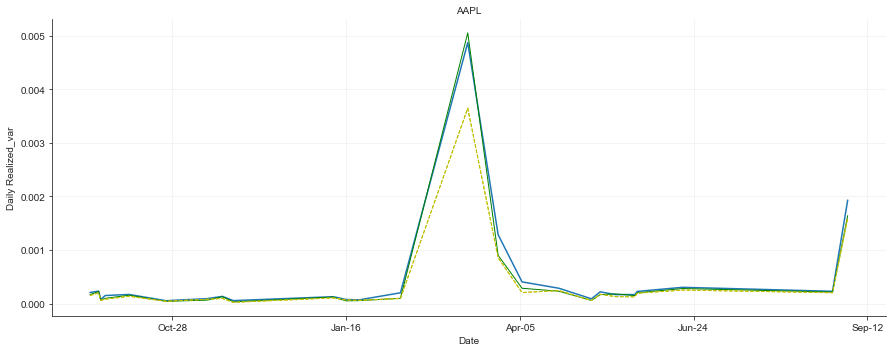

In [526]:
df3['date'] = pd.to_datetime(df3['date'])
g = sns.FacetGrid(df3.query('ticker == "AAPL" and Jump_num >0 '), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'RV')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'BV',color='g',ls='-', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'TV',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)


g = (g.map(plt.plot,'date', 'TV',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)


#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/variance.pdf", dpi=300)

#### Estimate $\Delta X_s^2\sigma_s^2$

- estimate spot variance : $\sigma_s^2 \approx \frac{RV_{s,s+k\Delta_n}}{k\Delta_n}$ 
 
 where $\Delta_n \to \infty$ and $k \asymp \Delta_n^{-\frac{1}{2}}$

In [527]:
k = int(np.ceil(np.sqrt(n)))

In [528]:
#calculate local var for all
data['local_var']  = (data.groupby(['ticker','date'])['rr_c'].rolling(k,min_periods=1).mean()*n).reset_index(drop=True)
data['second_part'] = data['local_var'] * data['rr_d']

In [529]:
data.query('jump==0').head(2)

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor,BV,cut,jump,rr,rr_c,rr_d,rr_c4,local_var,second_part
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.16,5.403398,0.003472,0.000001,09:35:00,0.000013,3.884301,0.000169,0.012139,0,1.205472e-05,1.205472e-05,0.0,1.453163e-10,0.000940,0.0
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.23,5.403713,0.000315,0.000001,09:40:00,0.000013,3.884301,0.000169,0.012139,0,9.924932e-08,9.924932e-08,0.0,9.850427e-15,0.000474,0.0


In [530]:
data.query('jump==1').head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor,BV,cut,jump,rr,rr_c,rr_d,rr_c4,local_var,second_part
44,AAPL,Apple,2019-09-20,2019-09-20 13:15:00,218.80,5.388158,-0.007513,1.703785e-06,13:15:00,0.000002,0.699197,0.000169,0.005150,1,0.000056,0.0,0.000056,3.185788e-09,0.000043,2.437757e-09
212,AAPL,Apple,2019-09-24,2019-09-24 14:15:00,218.83,5.388295,0.005820,5.350460e-07,14:15:00,0.000002,0.486555,0.000227,0.004970,1,0.000034,0.0,0.000034,1.147732e-09,0.000104,3.529885e-09
254,AAPL,Apple,2019-09-25,2019-09-25 11:15:00,220.34,5.395172,0.003774,1.031716e-06,11:15:00,0.000003,0.903993,0.000062,0.003554,1,0.000014,0.0,0.000014,2.028692e-10,0.000075,1.072958e-09
415,AAPL,Apple,2019-09-27,2019-09-27 11:40:00,218.60,5.387244,-0.008291,1.880996e-06,11:40:00,0.000003,0.829313,0.000099,0.004288,1,0.000069,0.0,0.000069,4.725832e-09,0.000020,1.389026e-09
1001,AAPL,Apple,2019-10-08,2019-10-08 15:00:00,226.24,5.421596,-0.005818,9.961792e-06,15:00:00,0.000002,0.573993,0.000157,0.004493,1,0.000034,0.0,0.000034,1.145414e-09,0.000132,4.483193e-09


In [536]:
df3['second_part'] = data.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)
df3['RV_var'] = 4*df3['second_part'] + 2*df3['IQ']
df3['IV_var'] = 2*df3['IQ']
df3['noise_var_prop'] = 4*df3['second_part'] / df3['RV_var']

In [537]:
df3.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,lower_99,upper_99,lower_95,upper_95,lower_90,upper_90,second_part,RV_var,IV_var,noise_var_prop
0,AAPL,2019-09-20,0.000152,0.000209,0.000169,1,0.000056,1.501593e-09,0.270399,0.000011,0.000293,0.000045,0.000260,0.000062,0.000242,2.437757e-09,1.275421e-08,3.003185e-09,0.764534
1,AAPL,2019-09-23,0.000084,0.000084,0.000079,0,0.000000,2.484929e-10,0.000000,0.000027,0.000141,0.000040,0.000128,0.000047,0.000121,0.000000e+00,4.969857e-10,4.969857e-10,0.000000
2,AAPL,2019-09-24,0.000200,0.000234,0.000227,1,0.000034,8.092886e-10,0.144826,0.000096,0.000304,0.000121,0.000279,0.000134,0.000266,3.529885e-09,1.573812e-08,1.618577e-09,0.897156
3,AAPL,2019-09-25,0.000063,0.000077,0.000062,1,0.000014,1.282152e-10,0.184049,0.000022,0.000104,0.000032,0.000095,0.000037,0.000089,1.072958e-09,4.548263e-09,2.564304e-10,0.943620
4,AAPL,2019-09-26,0.000075,0.000075,0.000063,0,0.000000,1.314733e-10,0.000000,0.000033,0.000117,0.000043,0.000107,0.000048,0.000102,0.000000e+00,2.629465e-10,2.629465e-10,0.000000


### Code book of df3 dataframe
- IQ: the estimator of IQ, that is $\frac{1}{3}\sum {r_i^c}^2$
- second part: the estimator of $\sum \Delta X_s^2\sigma_s^2$
- RV_var: the estimator of RV variance, that is $2\widehat{IQ}+4\sum \Delta X_s^2\sigma_s^2$
- IV_var: the estimator of IV variance, that is  $2\widehat{IQ}$
- noise_var_prop : $\frac{4\sum \Delta X_s^2\sigma_s^2}{RV\_var}$
- Jump_s2 : $\sum J_i^2$
- Jump_prop : $\frac{Jump\_s2}{RV}$
- TV : $\sum {r_i^c}^2 $
- BV : $\frac{n}{n-1}\sum \mid r_i\mid \mid r_{i-1}\mid $
- RV : $\sum {r_i}^2$

where $r_i^c$ is the continouous return and n is the oberservation number of unit day